<a href="https://colab.research.google.com/github/rafif22-sys/2025_VisiKomputer_TI-2A/blob/main/Jobsheet3_VisiKomputer_Praktikum3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Praktikum 3
from google.colab import files
files.upload()
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json",os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("Kaggle API  siap digunakan")
else:
  print("Kaggle.json belum ditemukan. Upload terlebih dahulu")

Saving kaggle.json to kaggle.json
Kaggle API  siap digunakan


In [2]:
#Langkah 2
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("Datasheet Pawpularity berhasil diekstrak")

Datasheet Pawpularity berhasil diekstrak


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

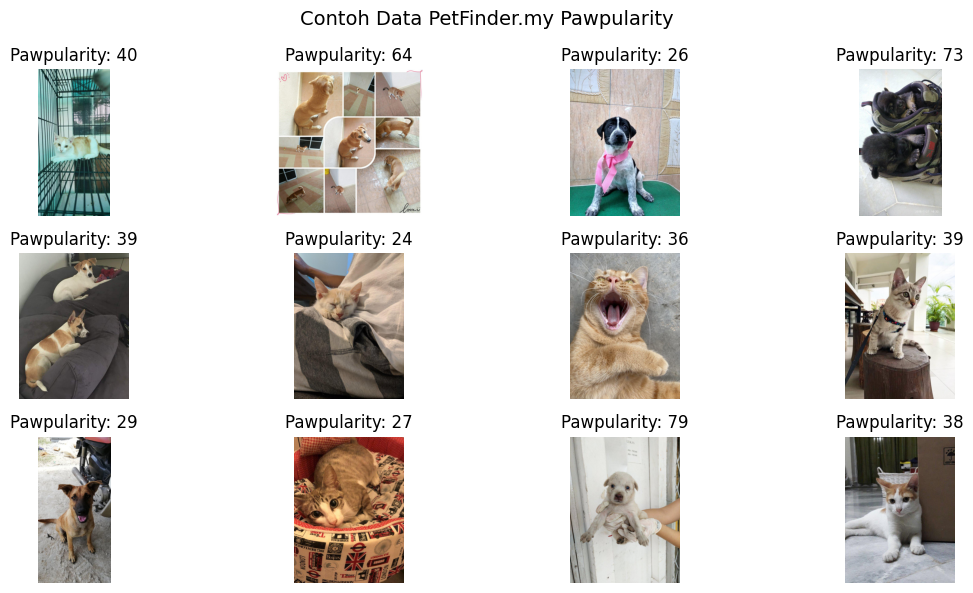

In [3]:
# Langkah 3
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

df = pd.read_csv('/content/paw/train.csv')
df['path'] =  df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

plt.figure(figsize=(12,6))
for i,row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3,4, i + 1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis("off")
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
# Langkah 4
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 42)

def load_image(path, label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = tf.cast(img, tf.float32) /255.0
  return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'],train_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds  = tf.data.Dataset.from_tensor_slices((val_df['path'],val_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap  digunakan - {len(train_df)} untuk training {len(val_df)} untuk validasi")


Dataset siap  digunakan - 7929 untuk training 1983 untuk validasi


In [20]:
# Langkah 5
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE,3),
    weights='imagenet'
)

base.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam',loss='mse', metrics=['mae'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_2 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
# Langkah 6
cb = [tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True),tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)]

history = model.fit(train_ds, validation_data=val_ds, epochs=10,callbacks=cb, verbose=1)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 91s 439ms/step - loss: 812.6782 - mae: 21.5172 - val_loss: 475.4764 - val_mae: 16.0702 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - loss: 411.5449 - mae: 14.9869 - val_loss: 429.7304 - val_mae: 15.5093 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - loss: 388.3441 - mae: 14.6488 - val_loss: 400.5029 - val_mae: 14.7617 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 206ms/step - loss: 369.9256 - mae: 14.2721 - val_loss: 386.9626 - val_mae: 14.4660 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - loss: 348.9144 - mae: 13.8659 - val_loss: 380.5204 - val_mae: 14.5567 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - loss: 346.9914 - mae: 13.7740 - val_loss: 376.3284 - val_mae: 14.1178 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 206ms/step - loss: 328.7858 - mae: 13.4173 - val_l

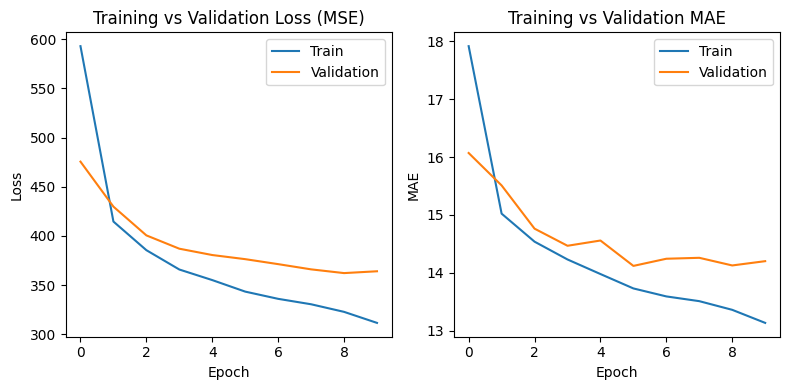

In [22]:
# Langkah 7
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch");plt.ylabel("Loss");plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch");plt.ylabel("MAE");plt.legend()
plt.tight_layout()
plt.show()

MAE = 14.13
RMSE = 19.03
R2 = 0.181


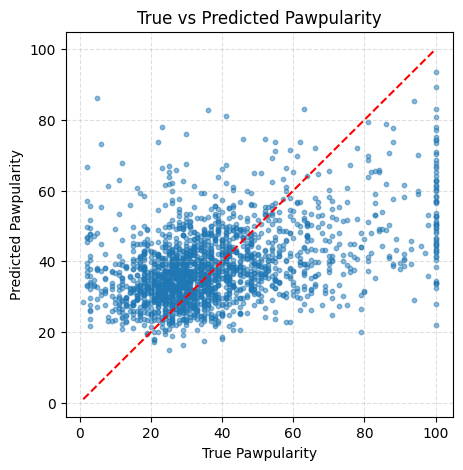

In [23]:
# Langkah 8
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R2 = {r2:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

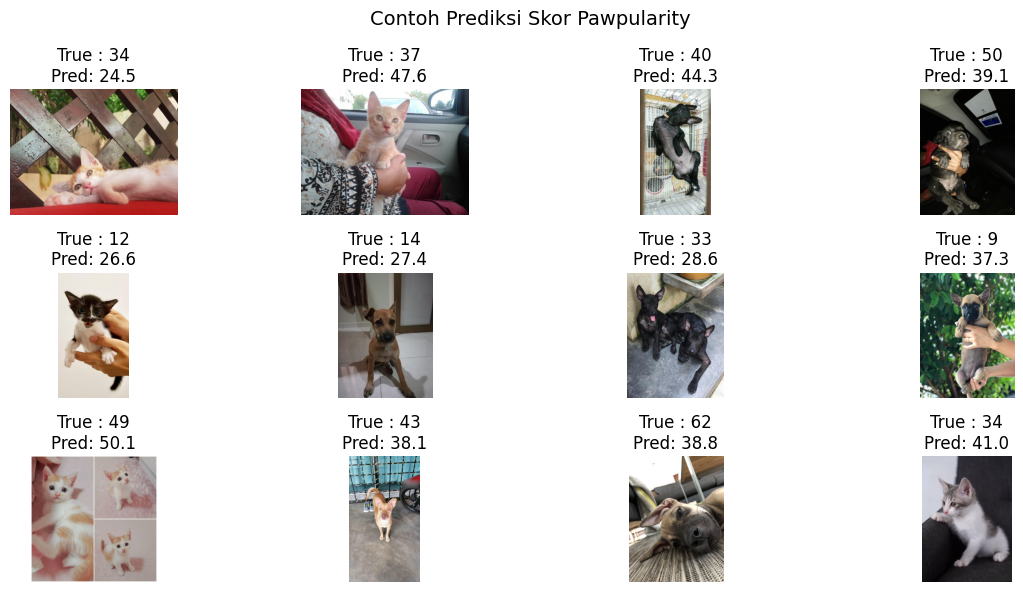

In [26]:
#Langkah 9
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=42)

plt.figure(figsize=(12,6))
for i,row in enumerate(sample_rows.itertuples()):
  img = Image.open(row.path)
  pred = model.predict(tf.expand_dims(load_image(row.path,row.Pawpularity)[0],0), verbose=0).ravel()[0]
  plt.subplot(3,4, i + 1)
  plt.imshow(img)
  plt.title(f"True : {row.Pawpularity}\nPred: {pred:.1f}")
  plt.axis("off")
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()